# Compare q values created by TOF simulator with those from a normal reduction

The current refnx reduction does not create a detailed resolution kernel. However, `refnx-models` does have code to simulate a detailed kernel via Monte-Carlo.

This notebook compares the Q values produced by the Monte Carlo simulation with those from reduction of a real sample. If they are equivalent then the detailed kernel produced by the Monte Carlo should be correct, and could be added to the dataset from the real sample

In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import simpson

from tof_simulator import ReflectSimulator, SpectrumDist

from refnx.reflect import Slab, Structure, SLD, ReflectModel
from refnx.dataset import ReflectDataset
from refnx.reduce import PlatypusNexus, PlatypusReduce, ReductionOptions

In [2]:
# process some real data
rdo = ReductionOptions(lo_wavelength=3.2, rebin_percent=2, hi_wavelength=18)
d0 = PlatypusReduce('PLP0049278.nx.hdf')
output = d0.reduce("PLP0049280.nx.hdf", **rdo)
dataset = output[0][0]
dataset.sort()
angles = output[1]['omega'][0]
wavelength = output[1]['m_lambda'][0]
pn = PlatypusNexus("PLP0049280.nx.hdf")
cat = pn.cat.cat
_chod = pn.chod()
dlambda = 100 * 0.68 *  _chod[1] / _chod[0]

/Users/anz/miniconda3/envs/dev3/lib/python3.9/site-packages/refnx/reduce/platypusnexus.py:1805: UserWarning: The foreground width ([50]) estimate does not match the divergence of the beam ([32.01913071]). Consider checking with manual beam finder.
  warnings.warn(
/Users/anz/miniconda3/envs/dev3/lib/python3.9/site-packages/refnx/reduce/platypusnexus.py:1805: UserWarning: The foreground width ([50]) estimate does not match the divergence of the beam ([32.01863098]). Consider checking with manual beam finder.
  warnings.warn(


In [3]:
dlambda

3.2819208039947663

In [4]:
air = SLD(0)
sio2 = SLD(3.47)
si = SLD(2.07)

s = air | sio2(225, 3) | si(0, 3)
model = ReflectModel(s, bkg=5e-7)

In [5]:
simulator0 = ReflectSimulator(model, angles[0],
                              direct_spectrum='PLP0049278.nx.hdf', rebin=2, lo_wavelength=3.2,
                              L12=cat['collimation_distance'],
                              L2S=cat['sample_distance'] - cat['slit3_distance'],
                              footprint=65, 
                              gravity=True, dlambda=dlambda, )
simulator0.sample(3400000)
simulator0.sample_direct(1500000)

/Users/anz/miniconda3/envs/dev3/lib/python3.9/site-packages/refnx/reduce/platypusnexus.py:2934: RuntimeWarning: specular ridge search did not work properly using last known centre
  warnings.warn(


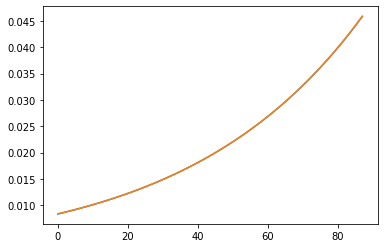

In [6]:
plt.plot(dataset.x)
plt.plot(np.sort(simulator0.q));

As we see in the above graph, the two sets of Q values overlap each other. We can therefore inject the detailed kernel from the MC simulation into a real dataset.

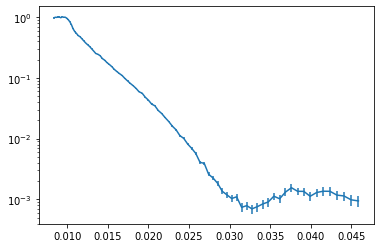

In [7]:
simulator0.reflectivity.plot()
plt.yscale('log')

In [ ]:
simulator0.sample(10000000)
rk = simulator0.resolution_kernel[0]
plt.plot(rk[0], rk[1])
simpson(rk[1], x=rk[0])

In [ ]:
dataset.x_err = simulator0.resolution_kernel